In [2]:
import numpy as np
import create_distribution as cr
import hamiltonian_2 as hm
import one_matrix_model as om
import importlib
importlib.reload(cr)
from qiskit.quantum_info import Statevector,partial_trace
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix, partial_trace
from scipy.optimize import minimize

### D=1, N=5

For N=5 , I also have some values, but the evaluation plot shows me that the results were not thath sensible. You can see it in the following plot:



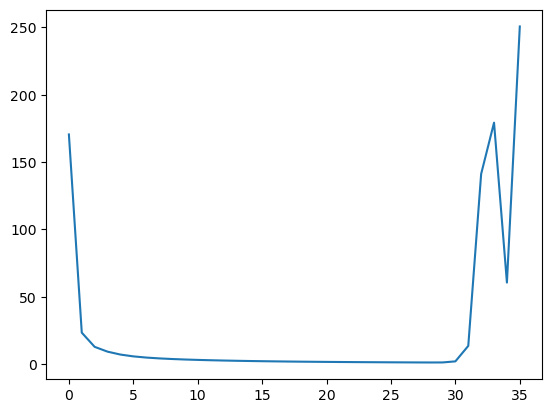

In [10]:
h_exp_val_4=[170.5,         23.37262847,  12.83911432,   9.2723476,    7.11411099,
   5.77182845,   4.89077474,   4.27333618,   3.81220756,   3.44899843,
   3.15125627,   2.90026801,   2.68468261,   2.49718012,   2.3327196
,   2.1876059 ,   2.05898326,   1.94455367,   1.84241458,   1.75096089,
   1.66882242,   1.59482111,   1.52793993,   1.46729884,   1.41213553,
   1.36179043,   1.31570939,   1.27365965,   1.23889821,   1.26258938,
   2.06477763,  13.55169196, 141.1725104 , 179.22575793,  60.54429435,
 250.63519809]
plt.plot(range(len(h_exp_val_4)), h_exp_val_4)

Because of this behaviour, I decided to go to my other dataset:

### Results for N=4, D=1 (2*2 Matrices, 2^4 discretization points for every eigenvalue)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35]


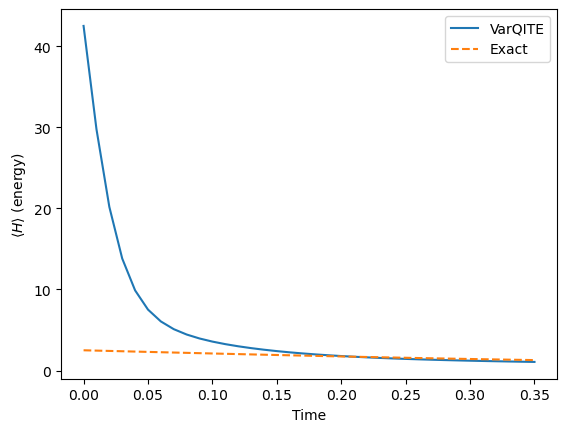

In [3]:
evolution_n_4 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/run_MORE_4.dipf_evolution.npy", allow_pickle=True).item()
scipy_n_4 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/scipyresult.npy",allow_pickle =True)

exact_exp_val = scipy_n_4[0]
print(evolution_n_4.times)
cr.compare_results_exp(evolution_n_4,exact_exp_val)


Varqite seems to run normal(I did not plot it with scipy generated evolution like we did in d=0 case, because it was taking too long, I will do it on the clusters in the future), so I continue:

In [11]:
#Hamiltonian a**( - lamda_1^2 - lambda_2 ^2)
power =2
qubits_per_dim = 4
D= 1
a =1
lambdas = []
for i in range(D+1):
    lambdas.append(om.create_lambda_2(i, D, qubits_per_dim))
hamiltonian = 0
for i in range(D+1):
    hamiltonian += (a ** 2) * lambdas[i].power(power)

In [13]:
#data
evolution_n_4 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/run_MORE_4.dipf_evolution.npy", allow_pickle=True).item()

In [45]:
state = Statevector(evolution_n_4.evolved_state) #builds the current state fir quantum circuit
value =state.expectation_value(om.vandermonde_2(1,4).power(2), list(range(0,8))) #this builds pho=|psi><psi, traces out the qubits 8..15, then calculates tr(operator * rho_traced), so what we want( I tried it also by numpy step by step)
print(value)

(1.0644712071703077+0j)


In [35]:
#the "result" in the function calculates the data without varqite. Function gives us how far we are. Pow is the power of vandermonde
def difference(value_, beta_, hamiltonian_, observable):
    result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
    return np.abs(value_-result)

In [43]:
beta=0.7
vandermonde = om.vandermonde_2(1,4).power(2)
print(difference(value,beta, hamiltonian,vandermonde))

2.102589749862542


But if we decide pow =1 , we find 0. So the integral $(\int (x-y)e^{(-x^2-y^2) * \beta})$ is correctly evaluated.  This give me the impression that the evolved state has the wrong $\beta$ 

In [23]:
#for pow 1, exp value
state.expectation_value(om.vandermonde_2(1,4).power(1), list(range(0,8)))

(6.554068745854206e-16+0j)

So I plotted the behaiour of differences with varying beta

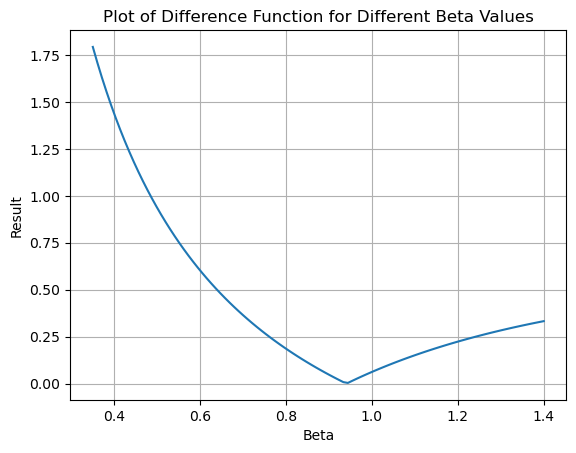

In [46]:
beta_values = np.linspace(0.35, 1.4, 100)
results = []
for beta in beta_values:
    result = difference(value, beta, hamiltonian, vandermonde)
    results.append(result)
plt.plot(beta_values, results)
plt.xlabel('Beta')
plt.ylabel('Result')
plt.title('Plot of Difference Function for Different Beta Values')
plt.grid(True)
plt.show()


In [47]:
# find best beta
def objective_function(beta):
    return difference(value,beta, hamiltonian,vandermonde)

initial_guess = 0.9
result = minimize(objective_function, initial_guess)
min_beta = result.x[0]
print("Minimum value of beta:", min_beta)
min_value = result.fun
print("Minimum value of the function:", min_value)

Minimum value of beta: 0.9405263311272964
Minimum value of the function: 3.702871786970263e-09


If I also evaluate the discretized Integral with the minimal beta found in mathematica, I find the value: 1.06447. 

compare it with varqite result: 1.0644712071703077. To verify this, I also try the found $\beta$ with other powers of vandermonde:

In [48]:
value_2  =state.expectation_value(om.vandermonde_2(1,4).power(4), list(range(0,8))) 

print(value_2)

(3.531221832169532+0j)


In [52]:
vandermonde_4 = om.vandermonde_2(1,4).power(4)
difference(value_2,0.9405263311272964, hamiltonian,vandermonde_4)

0.14572607866407283

calculated vander
loop: 0.8
loop: 0.8210526315789474
loop: 0.8421052631578948
loop: 0.8631578947368421
loop: 0.8842105263157896
loop: 0.9052631578947369
loop: 0.9263157894736842
loop: 0.9473684210526316
loop: 0.968421052631579
loop: 0.9894736842105263
loop: 1.0105263157894737
loop: 1.0315789473684212
loop: 1.0526315789473684
loop: 1.0736842105263158
loop: 1.094736842105263
loop: 1.1157894736842104
loop: 1.1368421052631579
loop: 1.1578947368421053
loop: 1.1789473684210527
loop: 1.2


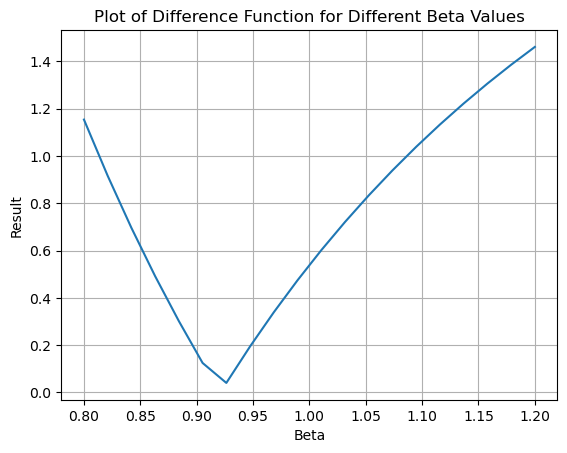

In [53]:
beta_values = np.linspace(0.8, 1.2, 20)
print("calculated vander")
results = []
for beta in beta_values:
    result = difference(value_2, beta, hamiltonian, vandermonde_4)
    results.append(result)
    print("loop:", beta)
plt.plot(beta_values, results)
plt.xlabel('Beta')
plt.ylabel('Result')
plt.title('Plot of Difference Function for Different Beta Values')
plt.grid(True)
plt.show()

So $\beta=$ 0.94 seems like again the evolved value since it is the least difference!

## Depth=2, N=3, D=1


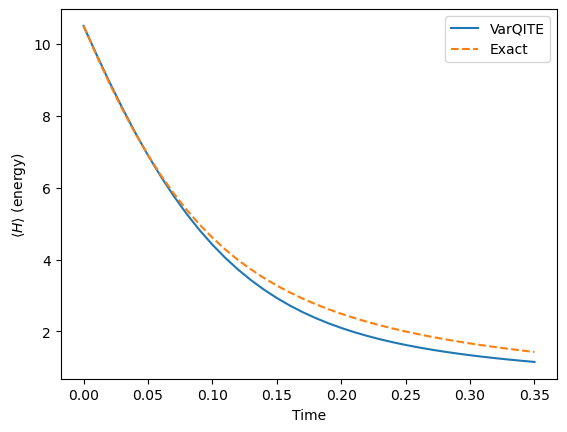

In [42]:
evolution_n_3 = np.load("//Users/salsa/MatrixModels/matrixmodels/remote/results/run_D_1_N_3_depth_2_evolution.npy",allow_pickle= True).item()
scipy_n_3 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/scipy_D_1_N_3_depth_2_evolution .npy",allow_pickle =True)

exact_exp_val_3 = scipy_n_3[0]
cr.compare_results_exp(evolution_n_3,exact_exp_val_3)

In [32]:
state_3= Statevector(evolution_n_3.evolved_state) #builds the current state fir quantum circuit
value_3 =state_3.expectation_value(om.vandermonde_2(1,3).power(2), list(range(0,6))) #this builds pho=|psi><psi, traces out the qubits 8..15, then calculates tr(operator * rho_traced), so what we want( I tried it also by numpy step by step)
print(value_3)

(1.1516466252609938+0j)


In [33]:
power =2
qubits_per_dim = 3
D= 1
a =1
lambdas = []
for i in range(D+1):
    lambdas.append(om.create_lambda_2(i, D, qubits_per_dim))
hamiltonian_3 = 0
for i in range(D+1):
    hamiltonian_3 += (a ** 2) * lambdas[i].power(power)

In [36]:
vandermonde_3 =om.vandermonde_2(1,3).power(2)
difference(value_3,0.7,hamiltonian_3,vandermonde_3)

0.2769596737831437

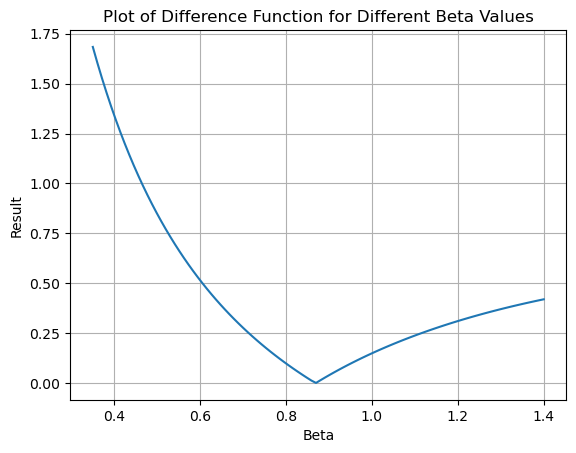

In [37]:
beta_values = np.linspace(0.35, 1.4, 100)
results = []
for beta in beta_values:
    result = difference(value_3,beta,hamiltonian_3,vandermonde_3)
    results.append(result)
plt.plot(beta_values, results)
plt.xlabel('Beta')
plt.ylabel('Result')
plt.title('Plot of Difference Function for Different Beta Values')
plt.grid(True)
plt.show()

In [39]:
def objective_function_2(beta):
    return difference(value_3,beta,hamiltonian_3,vandermonde_3)

initial_guess = 0.85
result = minimize(objective_function_2, initial_guess)
min_beta = result.x[0]
print("Minimum value of beta:", min_beta)
min_value = result.fun
print("Minimum value of the function:", min_value)

Minimum value of beta: 0.8687808481606651
Minimum value of the function: 5.88619597508e-10


## Depth =3, N=3, D=1

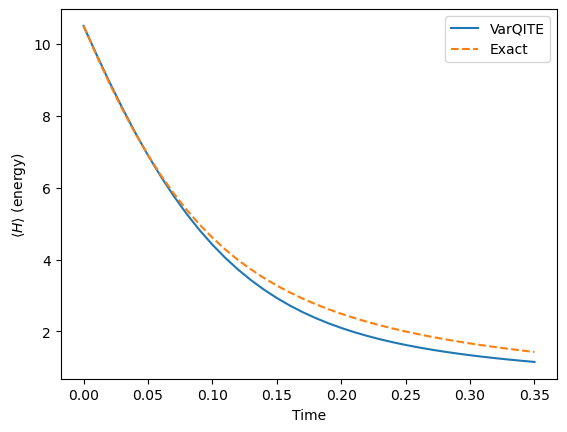

In [45]:
evolution_n_3_3 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/run_D_1_N_3_depth_3_evolution.npy",allow_pickle= True).item()
scipy_n_3_3 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/scipy_D_1_N_3_depth_3_evolution.npy .npy",allow_pickle =True)

exact_exp_val_3_3 = scipy_n_3_3[0]
cr.compare_results_exp(evolution_n_3_3,exact_exp_val_3_3)

(1.1516466252609945+0j)


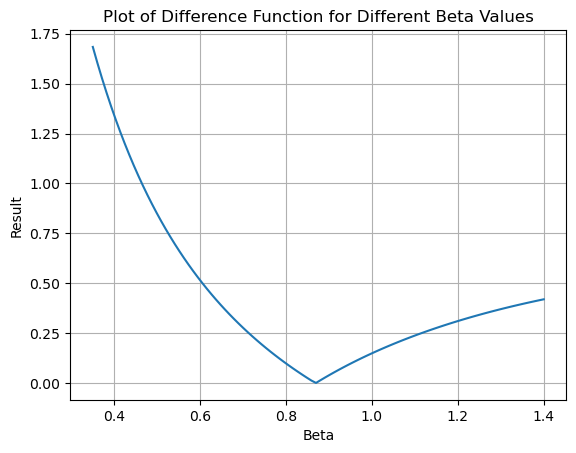

Minimum value of beta: 0.8687808481448003
Minimum value of the function: 6.095339788458887e-10


In [47]:
state_3_3= Statevector(evolution_n_3_3.evolved_state) #builds the current state fir quantum circuit
value_3_3 =state_3_3.expectation_value(om.vandermonde_2(1,3).power(2), list(range(0,6))) #this builds pho=|psi><psi, traces out the qubits 8..15, then calculates tr(operator * rho_traced), so what we want( I tried it also by numpy step by step)
print(value_3_3)


beta_values = np.linspace(0.35, 1.4, 100)
results = []
for beta in beta_values:
    result = difference(value_3,beta,hamiltonian_3,vandermonde_3)
    results.append(result)
plt.plot(beta_values, results)
plt.xlabel('Beta')
plt.ylabel('Result')
plt.title('Plot of Difference Function for Different Beta Values')
plt.grid(True)
plt.show()

def objective_function_3(beta):
    return difference(value_3_3,beta,hamiltonian_3,vandermonde_3)

initial_guess = 0.85
result = minimize(objective_function_3, initial_guess)
min_beta = result.x[0]
print("Minimum value of beta:", min_beta)
min_value = result.fun
print("Minimum value of the function:",min_value)
